Reading file: r01.edf...
Data loaded. Uploading to PostgreSQL...
Upload complete.
Reading from Database...
Statistics:
            Direct_1      Abdomen_1      Abdomen_2      Abdomen_3  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.340427       0.031705       0.028497       0.052548   
std        43.415497      20.946853      27.875419      15.986189   
min      -216.553304    -172.052625    -154.652360     -94.351440   
25%       -24.150369      -7.350112      -9.650147      -4.750072   
50%        -2.050031       2.050031      -0.150002      -0.250004   
75%        22.950350       9.050138       9.650147       4.650071   
max       316.154824     102.651566     162.252476      97.551489   

           Abdomen_4      timestamp  
count  300000.000000  300000.000000  
mean        0.059813     149.999500  
std        19.594323      86.602685  
min      -105.751614       0.000000  
25%        -7.450114      74.999750  
50%        -1.450022     149.99

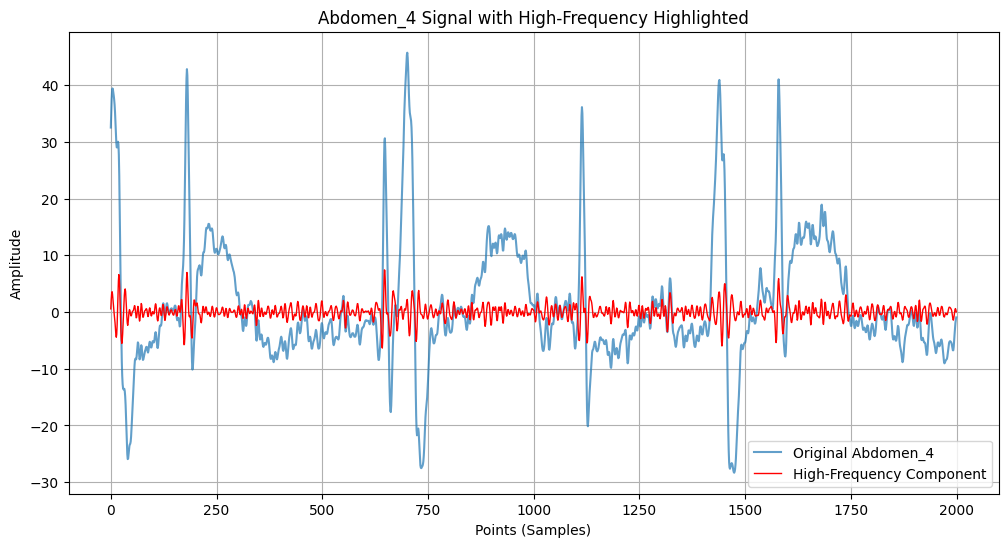

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sqlalchemy import create_engine
import pyedflib

# 1. Налаштування підключення до БД
DB_USER = "python_lect"
DB_PASSWORD = "python"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "adfed"

# Створення engine для підключення
# ВАЖЛИВО: додано ?client_encoding=utf8 для виправлення помилки на Windows
connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}?client_encoding=utf8"
engine = create_engine(connection_string)

# ==========================================
# ЧАСТИНА 1: ЗЧИТУВАННЯ REAL .EDF ФАЙЛУ
# ==========================================

edf_path = "r01.edf"
table_name = "re01"   # Назва таблиці в БД

print(f"Reading file: {edf_path}...")

try:
    # Відкриття та читання файлу
    with pyedflib.EdfReader(edf_path) as edf_reader:
        n_signals = edf_reader.signals_in_file
        signal_labels = [edf_reader.getLabel(i) for i in range(n_signals)]
        # Зчитуємо всі сигнали у список буферів
        sigbufs = [edf_reader.readSignal(i) for i in range(n_signals)]
        # Отримуємо частоту дискретизації
        sample_rate = int(edf_reader.getSampleFrequency(0))

    # Створення DataFrame
    # Транспонуємо (.T), щоб сигнали були у стовпцях
    df_raw = pd.DataFrame(sigbufs).T
    df_raw.columns = signal_labels
    
    # Створення шкали часу
    df_raw['timestamp'] = df_raw.index / sample_rate

    print("Data loaded. Uploading to PostgreSQL...")

    # Запис таблиці до бази даних
    df_raw.to_sql(table_name, engine, if_exists='replace', index=False)
    print("Upload complete.")

except Exception as e:
    print(f"Помилка при зчитуванні файлу або запису в БД.")
    print(f"Деталі помилки: {e}")
    # Створення порожнього DF для уникнення крашу далі
    df_raw = pd.DataFrame()

# ==========================================
# ЧАСТИНА 2: РОБОТА З БАЗОЮ ТА АНАЛІЗ
# ==========================================

try:
    # Читання сигналів з таблиці бази даних
    print("Reading from Database...")
    df = pd.read_sql_table(table_name, engine)

    # 3. Обробка та аналіз
    # Замінюємо Inf на NaN та видаляємо пусті значення
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    print("Statistics:")
    print(df.describe()) 

    # 4. Фільтрація (Фільтр Баттерворта)
    def butter_lowpass_filter(data, cutoff, fs, order=4):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y

    # Параметри
    fs = 1000       # Частота дискретизації (1 kHz)
    cutoff = 50     # Гц
    N = 2000        # Перші 2000 точок для візуалізації

    # Перевіряємо наявність каналу
    target_channel = 'Abdomen_4'
    if target_channel not in df.columns:
        print(f"Warning: Channel {target_channel} not found. Using first available column.")
        target_channel = df.columns[0]

    if not df.empty:
        signal = df[target_channel][:N].values
        
        # Виділення компонент
        low_freq = butter_lowpass_filter(signal, cutoff, fs)
        high_freq = signal - low_freq 

        # 5. Візуалізація
        plt.figure(figsize=(12, 6))
        plt.plot(signal, label=f'Original {target_channel}', alpha=0.7)
        plt.plot(high_freq, label='High-Frequency Component', color='red', linewidth=1)

        plt.title(f"{target_channel} Signal with High-Frequency Highlighted")
        plt.xlabel("Points (Samples)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("DataFrame is empty. Nothing to plot.")

except Exception as e:
    print(f"\n--- ВИНИКЛА ПОМИЛКА У 2-Й ЧАСТИНІ ---")
    print(e)
    print("-------------------------------------")